In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import inflection
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import xgboost as xgb

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from boruta import BorutaPy
from datetime import datetime, timedelta
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn import ensemble as en
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import svm

warnings.filterwarnings('ignore')

In [5]:
def data_types(df1):
    #abertura
    df1['abertura'] = df1['abertura'].apply(lambda x: x.replace(',','.'))
    df1['abertura'] = df1['abertura'].astype(float)

    #maximo
    df1['maximo'] = df1['maximo'].apply(lambda x: x.replace(',','.'))
    df1['maximo'] = df1['maximo'].astype(float)

    #minimo
    df1['minimo'] = df1['minimo'].apply(lambda x: x.replace(',','.'))
    df1['minimo'] = df1['minimo'].astype(float)

    #fechamento
    df1['fechamento'] = df1['fechamento'].apply(lambda x: x.replace(',','.'))
    df1['fechamento'] = df1['fechamento'].astype(float)

    #volume
    df1['volume'] = df1['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df1['volume'] = df1['volume'].astype(float)

    #quantidade
    df1['quantidade'] = df1['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df1['quantidade'] = df1['quantidade'].apply(lambda x: float(x))

    #data
    df1['data'] = df1['data'].apply(lambda x: x.replace('/','-'))
    df1['data'] = df1['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df1['data'] = pd.to_datetime(df1['data'], format='%d-%m-%Y')
    df1['hora'] = df1['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    
    return df1

def rename_columns(df1):
    cols_old = df1.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df1.columns = cols_new
    df1 = df1.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})
    
    return df1

def changing_time(df1):
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df1.loc[df1['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    hora_leilao = (df1['hora'].dt.hour >= 16) & (df1['hora'].dt.hour < 18) 
    df1 = df1.loc[hora_leilao,:]
    return df1

def clean_futuros(df_win):
    cols_old = df_win.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df_win.columns = cols_new
    df_win = df_win.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})

    df_win['abertura'] = df_win['abertura'].astype(float)

    #maximo

    df_win['maximo'] = df_win['maximo'].astype(float)

    #minimo

    df_win['minimo'] = df_win['minimo'].astype(float)

    #fechamento

    df_win['fechamento'] = df_win['fechamento'].astype(float)

    #volume
    df_win['volume'] = df_win['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df_win['volume'] = df_win['volume'].astype(float)

    #quantidade
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: float(x))

    #data
    df_win['data'] = df_win['data'].apply(lambda x: x.replace('/','-'))
    df_win['data'] = df_win['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df_win['data'] = pd.to_datetime(df_win['data'], format='%d-%m-%Y')
    df_win['hora'] = df_win['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df_win.loc[df_win['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    
    hora_leilao = (df_win['hora'].dt.hour >= 16) & (df_win['hora'].dt.hour < 18) 
    df_win = df_win.loc[hora_leilao,:]
    
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    return df_win

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))
   
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0])
    

In [129]:
# Carregar os dados de treino e teste
df_train = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/X_train.csv')
df_test = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/X_test.csv')

In [130]:
y_train = np.log(df_train['fechamento'])
y_test = np.log(df_test['fechamento'])

In [131]:
y_test.index = y_test.index +2922

In [132]:
y_train

0       3.085116
1       3.076851
2       3.082369
3       3.082827
4       3.085116
          ...   
2917    3.254243
2918    3.254629
2919    3.255015
2920    3.256172
2921    3.255401
Name: fechamento, Length: 2922, dtype: float64

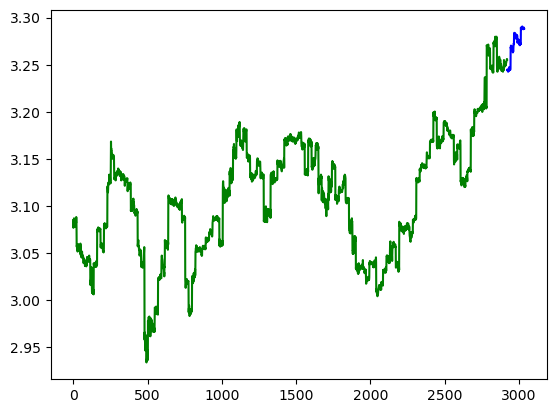

In [133]:
plt.plot(y_train, color='green')
plt.plot(y_test, color='blue')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21789.295, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21798.548, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21798.466, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21791.000, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21796.558, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21796.559, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21794.554, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21800.213, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21798.224, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-21798.224, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-21800.128, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21796.225, Time=0.31 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.324 seconds
                               SARIMAX Results                  

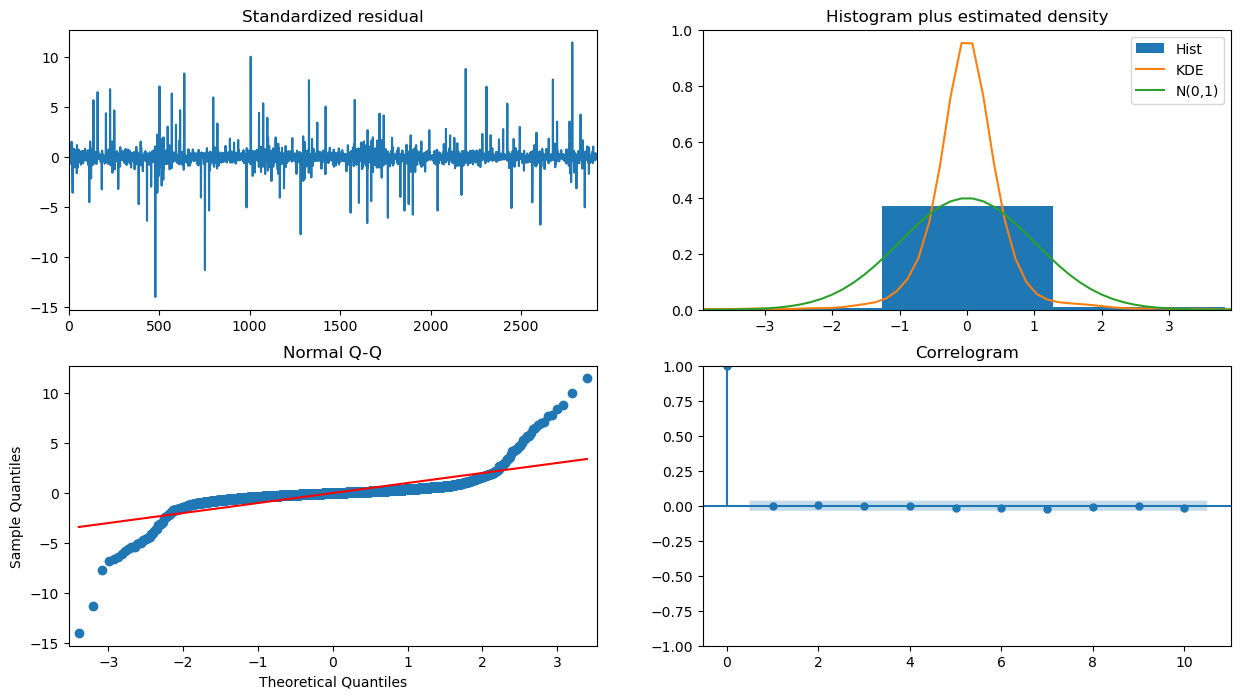

In [134]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [135]:
model = ARIMA(y_train, order=(1,1,0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             fechamento   No. Observations:                 2922
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10902.107
Date:                Mon, 29 May 2023   AIC                         -21800.213
Time:                        13:58:28   BIC                         -21788.254
Sample:                             0   HQIC                        -21795.906
                               - 2922                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0619      0.014     -4.307      0.000      -0.090      -0.034
sigma2      3.354e-05   1.84e-07    182.574      0.000    3.32e-05    3.39e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            255884.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
forecast = fitted.forecast(115, alpha=0.05)

In [137]:
print(forecast)

2922    3.255448
2923    3.255445
2924    3.255446
2925    3.255446
2926    3.255446
          ...   
3032    3.255446
3033    3.255446
3034    3.255446
3035    3.255446
3036    3.255446
Name: predicted_mean, Length: 115, dtype: float64


In [113]:
y_test

2922    3.244544
2923    3.244544
2924    3.244933
2925    3.243373
2926    3.244544
          ...   
3032    3.288029
3033    3.288775
3034    3.289521
3035    3.288775
3036    3.288402
Name: fechamento, Length: 115, dtype: float64

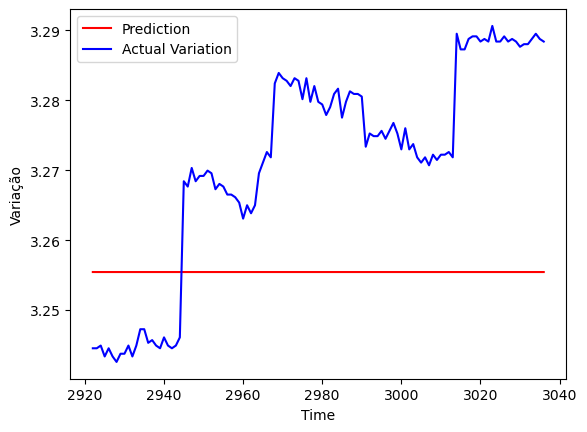

In [125]:
plt.plot(forecast, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Actual Variation')
plt.xlabel('Time')
plt.ylabel('Variação')
plt.legend()

In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Definir as colunas de features e resposta
cols_features = ['variacao_win', 'quantidade', 'volume']
col_target = 'variacao'

# Filtrar os dados de treino e teste
X_train = df_train[cols_features]
y_train = df_train[col_target]
X_test = df_test[cols_features]

# Definir o modelo SARIMAX
model = SARIMAX(y_train, exog=X_train, order=(1, 0, 0))  # Ordem do modelo: AR(1)

# Treinar o modelo SARIMAX
model_fit = model.fit()

# Fazer as previsões para o período de teste
predictions = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)

# Imprimir as previsões
print(predictions)


2922    0.000709
2923    0.000203
2924    0.000102
2925    0.001388
2926   -0.000926
          ...   
3032    0.000151
3033   -0.001134
3034   -0.000321
3035   -0.000683
3036    0.000229
Name: predicted_mean, Length: 115, dtype: float64


In [47]:
df_test['variacao']

0      0.000780
1      0.000000
2      0.000390
3      0.000781
4      0.000780
         ...   
110   -0.001119
111   -0.000745
112   -0.000745
113    0.000373
114    0.001495
Name: variacao, Length: 115, dtype: float64

In [43]:
predictions = predictions.reset_index(drop=True)

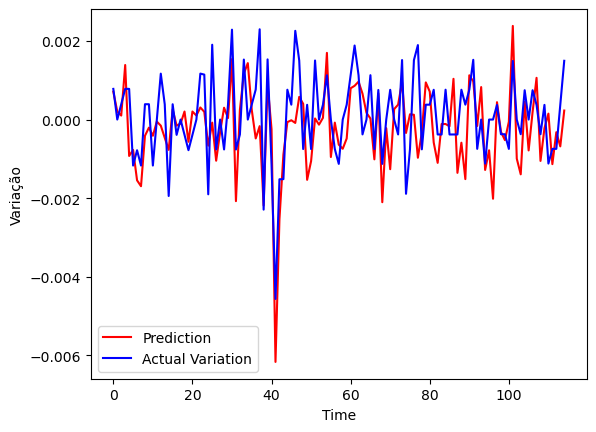

In [44]:
plt.plot(predictions, color='red', label='Prediction')
plt.plot(df_test['variacao'], color='blue', label='Actual Variation')
plt.xlabel('Time')
plt.ylabel('Variação')
plt.legend()

In [45]:
mape = mt.mean_absolute_percentage_error(df_test['variacao'], predictions)

In [48]:
mae = mt.mean_absolute_error(df_test['variacao'], predictions)

In [51]:
rmse = np.sqrt(mae)

In [53]:
df_test['variacao'].sum()

0.009057962323520404

In [54]:
predictions.sum()

-0.025514228252321428